In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from numba import njit

In [2]:
# constants #

ki = 1.2e-06 # 1/s
kp = 500 # L/mol*s
ktc = 6e06 # L/mol*s
ktd = 6e06 # L/mol*s
kfm = 9.1e-02 # L/mol*s
kfp = 0.5 # L/mol*s
kpp = 0.05 # L/mol*s
f = 1.0
M0 = 8.4 # mol/L
I0 = 0.002 #mol/L

In [3]:
@njit
def lambda_0(I): # moment zero for radicals
    return np.sqrt((2 * f * ki * I) / ktd)

@njit
def lambda_1(M, L0, mu_1, mu_2): # momento one for radicals
    num = kp * M * L0 + kfp * L0 * mu_2
    denm = kfm * M + ktd * L0 + kfp * mu_1
    
    return num / denm

In [4]:
# Crear un array de 400 valores para n

n = np.arange(1, 401) * 2500  

# Crear un array con 400 elementos para b de propagación
b_p = 1.0 / np.diff(n)
b_p = np.append(b_p, b_p[-1])

In [5]:
def a_fraction(n):
    """
    Calcula la matriz de resultados con los índices, pares (p, l) y el valor de `ai`.

    Args:
        n (array-like): Array de valores a procesar.

    Returns:
        numpy.ndarray: Matriz con las columnas [idx, p, l, ai].
    """
    n = np.array(n)  # Asegurarse de que 'n' sea un array de numpy
    results = []  # Lista para almacenar los resultados

    for p in range(len(n)):
        for l in range(p, len(n)):
            nj, nk = n[p], n[l]
            njk = nj + nk
            idx = np.searchsorted(n, njk, side="right") - 1  # Encontrar índice del intervalo
            if idx >= 0 and idx < len(n) - 1:
                if njk == n[idx]:
                    ai = 0.0
                else:
                    ai = (n[idx + 1] - (n[p] + n[l])) / (n[idx + 1] - n[idx])
                results.append((idx, p, l, ai))  # Agregar resultado a la lista

    return np.array(results, dtype=object)  # Convertir la lista en un array NumPy

In [6]:
def b_fraction(a_results):
    # Filtrar las filas donde el primer elemento no sea 0
    filtered_results = a_results[a_results[:, 0] != 0]

    # Crear una copia para aplicar las transformaciones
    b = np.copy(filtered_results)

    # Incrementar el primer elemento en 1 y modificar el cuarto elemento
    b[:, 0] = b[:, 0] + 1  # Incrementar el primer elemento
    b[:, 3] = 1.0 - b[:, 3]  # Restar el cuarto elemento de 1.0

    return b

In [7]:
ai = a_fraction(n)
bi = b_fraction(ai)

In [8]:
ai.shape

(39800, 4)

In [9]:
from collections import defaultdict
import numpy as np

ai_dict = defaultdict(list)
bi_dict = defaultdict(list)

# Agrupar los datos, ignorando filas con el último valor = 0 y asegurando enteros
for row in ai:
    idx = int(row[0])  # Índice principal
    if row[3] != 0:  # Si el último valor NO es 0, lo agregamos
        ai_dict[idx].append([int(row[1]), int(row[2]), row[3]])  # Asegurar enteros en las dos primeras columnas

for row in bi:
    idx = int(row[0])  # Índice principal
    if row[3] != 0:  # Si el último valor NO es 0, lo agregamos
        bi_dict[idx].append([int(row[1]), int(row[2]), row[3]])  # Asegurar enteros en las dos primeras columnas

# Convertimos listas en arrays de NumPy asegurando que las dos primeras columnas sean enteros
for key in ai_dict:
    arr = np.array(ai_dict[key], dtype=object)  # Convertir a dtype=object para modificar por columnas
    arr[:, :2] = arr[:, :2].astype(int)  # Convertir las dos primeras columnas a enteros
    ai_dict[key] = np.array(arr.tolist(), dtype=object)  # Reconvertir a un array sin forzar float

for key in bi_dict:
    arr = np.array(bi_dict[key], dtype=object)
    arr[:, :2] = arr[:, :2].astype(int)
    bi_dict[key] = np.array(arr.tolist(), dtype=object)


In [10]:
bi_dict[2]

array([[0, 0, 1.0]], dtype=object)

In [11]:
bi_idx = bi_dict.get(44, None)
bi_idx[:, 0]


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21], dtype=object)

In [12]:
# Función principal
def balances_KR(t, y):
    # Descomposición del vector de estados
    I = y[0]
    M = y[1]
    mu_0 = y[2]
    mu_1 = y[3]
    mu_2 = y[4]
    Nrd = y[5:405]  # Radicales
    Npd = y[405:805]  # Polímeros

    # Cálculo de momentos de los radicales
    L0 = lambda_0(I)
    L1 = lambda_1(M, L0, mu_1, mu_2)

    # Ecuaciones diferenciales
    dIdt = -ki * I
    dMdt = -(kp + kfm) * M * L0
    dmu_0dt = kfm * M * L0 + ktd * L0**2
    dmu_1dt = kp * M * L0
    dmu_2dt = kp * M * (L0 + 2 * L1)

    # Ecuaciones para los radicales y polímeros
    dNrdt = np.zeros_like(Nrd)
    dNpdt = np.zeros_like(Npd)

    for idx in range(len(Nrd)):
        if idx == 0:
            dNrdt[idx] = (- (kfm * M + (ktd + ktc) * L0 + kfp * mu_1) * Nrd[idx]
                          - kp * M * (b_p[idx] * Nrd[idx])
                          + kfp * L0 * n[idx] * Npd[idx]
                          + kfm * M * L0 + 2 * f * ki * I)
        else:
            dNrdt[idx] = (- (kfm * M + (ktd + ktc) * L0 + kfp * mu_1) * Nrd[idx]
                          + kp * M * (b_p[idx-1] * Nrd[idx-1] - b_p[idx] * Nrd[idx])
                          + kfp * L0 * n[idx] * Npd[idx])

    for idx in range(len(Npd)):
        # Obtener los valores desde el diccionario o None si no existen
        ai_idx = ai_dict.get(idx, None)
        bi_idx = bi_dict.get(idx, None)

        # Inicializar sumas
        suma_1 = 0.0
        suma_2 = 0.0

        # Solo calcular si hay datos en ai_idx
        if ai_idx is not None and len(ai_idx) > 0:
            suma_1 = np.sum(ai_idx[: , 2] * Nrd[ai_idx[:, 0]] * Nrd[ai_idx[:, 1]])

        # Solo calcular si hay datos en bi_idx
        if bi_idx is not None and len(bi_idx) > 0:
            idx_0 = np.array(bi_idx[:, 0], dtype=int)  # Convertir la primera columna a int
            idx_1 = np.array(bi_idx[:, 1], dtype=int)  # Convertir la segunda columna a int
            coef = bi_idx[:, 2]  # La tercera columna sigue siendo flotante

            suma_2 = np.sum(coef * Nrd[idx_0] * Nrd[idx_1])

        # Ecuación diferencial
        dNpdt[idx] = (- kfp * L0 * n[idx] * Npd[idx]
                    + (kfm * M + ktd * L0 + kfp * mu_1) * Nrd[idx]
                    + (ktc / 2) * (suma_1 + suma_2))


    # Concatenación de derivadas
    return np.concatenate(([dIdt, dMdt, dmu_0dt, dmu_1dt, dmu_2dt], dNrdt, dNpdt))

In [21]:
y0 = np.zeros(805)
y0[0] = I0
y0[1] = M0

time = [0, 100]
t_get = [100, 1000, 3500, 10000, 15000, 40000, 60000, 71100, 90000]

In [22]:
sol = solve_ivp(
      balances_KR,
      time, 
      y0, 
      #t_eval=t_get,
      method='LSODA',
      rtol=1e-04,
      atol=1e-06,
      )

In [23]:
sol.y[505]

array([ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        2.45787659e-231,  1.02436785e-128,  3.90174009e-100,
        2.18260438e-089,  6.18572612e-083,  2.54418300e-078,
        1.06428392e-074,  1.65022558e-071,  8.99051929e-069,
        2.26238319e-066,  2.78841075e-064,  1.97912523e-062,
        8.98363084e-061,  1.85415735e-059,  3.07042155e-058,
        4.03932207e-057,  1.88588163e-030,  1.42675903e-029,
        8.08106722e-029,  2.78175339e-024,  6.48005736e-024,
        9.64883188e-024, -1.68652975e-022])

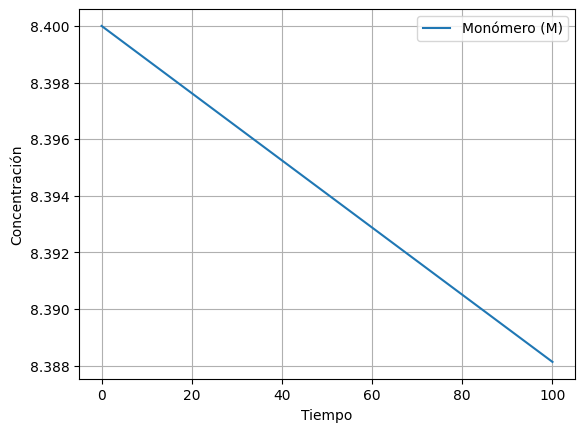

In [24]:
# Visualización
import matplotlib.pyplot as plt

#plt.plot(sol.t, sol.y[0], label="Iniciador (I)")
plt.plot(sol.t, sol.y[1], label="Monómero (M)")
plt.legend()
plt.xlabel("Tiempo")
plt.ylabel("Concentración")
plt.grid()
plt.show()